In [1]:
import csv
import re
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas # noqa

import ipywidgets as w

In [2]:
ANALYSIS_ROOT = Path("analysis")
ANALYSIS_SUMMARY_RE = re.compile(
    "\[INFO\] size (?P<arity>[0-9]*): (?P<count>[0-9]*) over (?P<total>[0-9]*) \((< )?[0-9]*%\)")
ANALYSIS_CLASSIF_RE = re.compile("Computed (.*)")


In [3]:
EXPORT_ROOT = Path("export")
EXPORT_PARAMS_RE = re.compile(
    "^GenericSample_"
    "([0-9]*)Cores_"
    "([0-9]*)Cl_"
    "([0-9]*)Dsp_"
    "([0-9]*)Prt_"
    "([0-9]*)CorePerBank"
    "((_noDMA)?).*"
)


In [4]:
def load_semantics() -> pd.DataFrame:
    records = []
    semantics_path: Path
    for semantics_path in EXPORT_ROOT.glob("*SemanticsSize.txt"):
        if (m := EXPORT_PARAMS_RE.match(semantics_path.name)) is not None:
            name = semantics_path.stem.split("_", 1)[1].removesuffix("SemanticsSize")
            # Extract platform parameters from filename
            entry_header = {
                "name": name,
                "cores": int(m.group(1)),
                "clusters": int(m.group(2)),
                "dsps": int(m.group(3)),
                "partitions": int(m.group(4)),
                "cores_per_bank": int(m.group(5)),
                "has_dma": len(m.group(6)) == 0,
            }
            # Collect semantic size
            with semantics_path.open("r") as semantics_file:
                semantics_csv = csv.reader(semantics_file)
                _ = next(semantics_csv)
                for row in semantics_csv:
                    entry = {
                        **entry_header,
                        "arity": int(row[0]),
                        "count": int(row[1]),
                    }
                    records.append(entry)
    semantics = pd.DataFrame.from_records(records)
    return semantics

In [5]:
semantics = load_semantics()
semantics

,name,cores,clusters,dsps,partitions,cores_per_bank,has_dma,arity,count
0,4Cores_2Cl_1Dsp_1Prt_1CorePerBank,4,2,1,1,1,True,2,236
1,4Cores_2Cl_1Dsp_1Prt_1CorePerBank,4,2,1,1,1,True,3,1216
2,4Cores_2Cl_1Dsp_1Prt_1CorePerBank,4,2,1,1,1,True,4,3456
3,4Cores_2Cl_1Dsp_1Prt_1CorePerBank,4,2,1,1,1,True,5,5120
4,4Cores_2Cl_1Dsp_1Prt_1CorePerBank,4,2,1,1,1,True,6,3072
...,...,...,...,...,...,...,...,...,...
251,4Cores_4Cl_1Dsp_2Prt_2CorePerBank_noDMA,4,4,1,2,2,False,2,78
252,4Cores_4Cl_1Dsp_2Prt_2CorePerBank_noDMA,4,4,1,2,2,False,3,216
253,4Cores_4Cl_1Dsp_2Prt_2CorePerBank_noDMA,4,4,1,2,2,False,4,297
254,4Cores_4Cl_1Dsp_2Prt_2CorePerBank_noDMA,4,4,1,2,2,False,5,162


In [53]:
records = []
analysis_path: Path
for analysis_path in ANALYSIS_ROOT.glob("*itf_calculus_summary.txt"):
    if (m := EXPORT_PARAMS_RE.match(str(analysis_path.name))) is not None:
        name = analysis_path.stem.split("_", 1)[1].removesuffix("_itf_calculus_summary")
        entry_header = {
            "name": name,
            "cores": int(m.group(1)),
            "clusters": int(m.group(2)),
            "dsps": int(m.group(3)),
            "partitions": int(m.group(4)),
            "cores_per_bank": int(m.group(5)),
            "has_dma": len(m.group(6)) == 0,
        }
        with analysis_path.open("r") as analysis_file:
            classif: str | None = None
            known_classifications = ["ITF", "ITF-free", "Redundant"]
            classified = {}
            # FIX Count transactions from semantics
            totals = {t.arity: t.count for t in semantics[semantics["name"] == name].itertuples() if t.count > 0}
            classified = {t: {c: 0 for c in known_classifications} for t in totals}
            for line in analysis_file:
                if (m := ANALYSIS_CLASSIF_RE.match(line)) is not None:
                    classif = m.group(1)
                if (m := ANALYSIS_SUMMARY_RE.match(str(line))) is not None:
                    arity, tr_count, tr_total = map(int, m.group("arity", "count", "total"))
                    assert totals.get(arity, tr_total) == tr_total
                    totals[arity] = tr_total
                    classified[arity][classif] = tr_count
            for arity in totals:
                classified[arity]["Redundant"] = totals[arity] - sum(classified[arity].values())
            for arity in classified:
                for classif, tr_count in classified[arity].items():
                    records.append({
                        **entry_header,
                        "classification": classif,
                        "arity": str(arity),
                        "count": tr_count,
                    })
classifications = pd.DataFrame.from_records(records)
classifications

,name,cores,clusters,dsps,partitions,cores_per_bank,has_dma,classification,arity,count
0,4Cores_2Cl_0Dsp_1Prt_2CorePerBank,4,2,0,1,2,True,ITF,2,8
1,4Cores_2Cl_0Dsp_1Prt_2CorePerBank,4,2,0,1,2,True,ITF-free,2,82
2,4Cores_2Cl_0Dsp_1Prt_2CorePerBank,4,2,0,1,2,True,Redundant,2,0
3,4Cores_2Cl_0Dsp_1Prt_2CorePerBank,4,2,0,1,2,True,ITF,3,4
4,4Cores_2Cl_0Dsp_1Prt_2CorePerBank,4,2,0,1,2,True,ITF-free,3,202
...,...,...,...,...,...,...,...,...,...,...
667,2Cores_1Cl_0Dsp_1Prt_2CorePerBank,2,1,0,1,2,True,ITF-free,2,18
668,2Cores_1Cl_0Dsp_1Prt_2CorePerBank,2,1,0,1,2,True,Redundant,2,0
669,2Cores_1Cl_0Dsp_1Prt_2CorePerBank,2,1,0,1,2,True,ITF,3,0
670,2Cores_1Cl_0Dsp_1Prt_2CorePerBank,2,1,0,1,2,True,ITF-free,3,12


In [62]:
classification_counts = classifications.groupby(
    by=["name", "arity", "classification"]
)["count"].max().sort_index(ascending=False)

classification_counts.hvplot(
    kind="barh",
    by='classification',
    groupby='name',
    x='arity',
    y='count',
    legend='bottom_right',
    widget_location='top',
    stacked=True,
    color=["#97CC04", "#FF9000", "#246EB9"],
)


Column
    [0] WidgetBox(align=('center', 'start'))
        [0] Select(name='name', options=[np.str_('4Cores_4Cl_1Dsp_...], value=np.str_('4Cores_4Cl_1Dsp_2...)
    [1] HoloViews(DynamicMap, height=300, sizing_mode='fixed', widget_location='top', width=700)

In [55]:
classification_counts


name                                     arity  classification
1Cores_1Cl_0Dsp_1Prt_1CorePerBank        2      ITF                 0
                                                ITF-free            6
                                                Redundant           0
2Cores_1Cl_0Dsp_1Prt_1CorePerBank        2      ITF                 3
                                                ITF-free           24
                                                                 ... 
4Cores_4Cl_1Dsp_2Prt_2CorePerBank_noDMA  4      ITF-free          256
                                                Redundant          41
                                         5      ITF                 0
                                                ITF-free          128
                                                Redundant          34
Name: count, Length: 672, dtype: int64

In [26]:
classifications.dtypes

name              object
cores              int64
clusters           int64
dsps               int64
partitions         int64
cores_per_bank     int64
has_dma             bool
classification    object
arity             object
count              int64
dtype: object

In [9]:
semantics_sizes = \
semantics.groupby(by=["name", "cores", "clusters", "dsps", "partitions", "cores_per_bank", "has_dma"])[
    "count"].sum()
semantics_sizes

name                                     cores  clusters  dsps  partitions  cores_per_bank  has_dma
1Cores_1Cl_0Dsp_1Prt_1CorePerBank        1      1         0     1           1               True           6
1Cores_1Cl_0Dsp_1Prt_1CorePerBank_noDMA  1      1         0     1           1               False          0
2Cores_1Cl_0Dsp_1Prt_1CorePerBank        2      1         0     1           1               True          54
2Cores_1Cl_0Dsp_1Prt_1CorePerBank_noDMA  2      1         0     1           1               False          9
2Cores_1Cl_0Dsp_1Prt_2CorePerBank        2      1         0     1           2               True          39
                                                                                                       ...  
4Cores_4Cl_1Dsp_1Prt_4CorePerBank_noDMA  4      4         1     1           4               False        753
4Cores_4Cl_1Dsp_2Prt_1CorePerBank        4      4         1     2           1               True       13100
4Cores_4Cl_1Dsp_2Prt_1CorePe

<Axes: xlabel='arity', ylabel='count'>

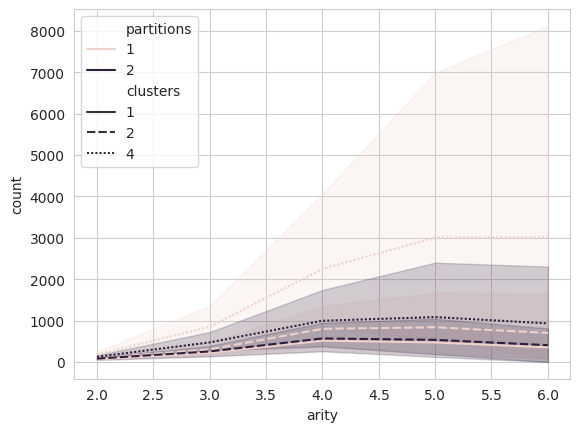

In [10]:
sns.lineplot(
    x="arity",
    y="count",
    style="clusters",
    hue="partitions",
    data=semantics,
    # estimator="max",
    # style="dsps"
)